In [1]:
from pymongo import MongoClient
import re, string, nltk, csv
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

print("Connecting to MongoDB ...")
client = MongoClient('localhost:27017')
db = client['comments']

Connecting to MongoDB ...


In [2]:
rawComments = db['rawComments'].find()

In [3]:
def translate_numbers(word):
    word = word.replace('2', 'a')
    word = word.replace('3', 'a')
    word = word.replace('5', "kh")
    word = word.replace('7', 'h')
    word = word.replace('8', "gh")
    word = word.replace('9', "k")
    return word


In [4]:
def remove_redundant_letters(word):
    return re.sub(r'(.)\1+', r'\1', word) 

In [5]:
def cleanComment(comment):

    tokens = comment.split()

    #ignoring case by converting the words to lowercase letters
    tokens = [word.lower() for word in tokens]

    # translate arabic phonetic numbers used in tunisian dialect  (for example: '7' --> 'h', '5' --> "kh")
    tokens = [translate_numbers(w) for w in tokens]

    #remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]

    #remove redundant letters (for example: "mahleeeeeh" --> "mahleh")
    tokens = [remove_redundant_letters(w) for w in tokens]

    #remove short words of length <=2 because in general they are insignificant and will slow down the process
    tokens = [word for word in tokens if len(word) > 2]

    cleancomment = " ".join(tokens)
    
    

    return cleancomment

In [6]:
def checkSimilarity(word1, word2):
    return nltk.edit_distance(word1, word2) < 2 

In [7]:
def sentimentScore(words, dictionary):
    scoreComment = tokenCount = 0

    for word in words:
        for token in dictionary:
            if checkSimilarity(word, token[0]):
                if token[1] != "":
                    scoreComment = scoreComment + int(token[1])
                    tokenCount = tokenCount + 1
                    break
    if tokenCount != 0:
        scoreComment = scoreComment / tokenCount

    return scoreComment

In [8]:
dictionary = []
with open('C:/Users/INFOTEC/Desktop/PI/cleanDictionary.csv', 'r', newline='',encoding="utf8") as dictionaryFile:
    dictionaryReader = csv.reader(dictionaryFile, delimiter=',')
    i = 0
    for row in dictionaryReader:
        if (row[1] == 0):
            continue
        dictionary.append([row[0], row[1]])


print("Cleaning comments")

Cleaning comments


In [24]:
for comment in rawComments:
    existant = db['cleanComments'].find({"id": comment["id"]}).count()
    if existant:
        continue

    cleancomment = cleanComment(comment["review"])
    


    words = cleancomment.split()

    score = sentimentScore(words, dictionary)
    
    
    db.cleanComments.insert({
        "_id": comment["_id"],
        "id": comment["id"],
        "review": cleancomment,
        "score": score
    })



In [10]:
print(rawComments)

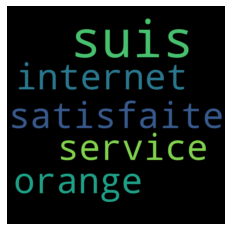

In [27]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(cleancomment)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
wordcloud.to_file('C:/Users/INFOTEC/Desktop/PI/world.png')